# CEL PROJEKTU

Celem projektu było wykrycie stanu płodu, na podstawie przetworzonych kardiogramów płodu (KTG).

Zastosowano Mamdaniego typu I oraz typu II.

## Wczytanie potrzebnych bibliotek

In [82]:
from fuzzy_expert.variable import FuzzyVariable
from fuzzy_expert.rule import FuzzyRule
from fuzzy_expert.inference import DecompositionalInference

from pyit2fls import IT2FS, tri_mf, rtri_mf, ltri_mf, \
    trapezoid_mf, IT2Mamdani, IT2FS_plot, min_t_norm, max_s_norm, \
    TR_plot, crisp

from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')
pd.set_option('display.max_columns', None)
np.random.seed(2)

## Dane

Dane wykorzystane w pracy pochodzą z **UC Irvine Machine Learning Repository**.
Repozytorium uczenia maszynowego UCI to zbiór baz danych, teorii domen i generatorów danych, które są używane przez społeczność uczenia maszynowego do empirycznej analizy algorytmów uczenia maszynowego.
Dane składają się z 2126 instancji, czyli kardiotokogramów płodu (KTG), które zostały automatycznie przetworzone i zmierzone pod kątem odpowiednich cech diagnostycznych przy pomocy oprogramowania SisPorto®.
KTG zostały również sklasyfikowane przez trzech ekspertów - położników, a każdemu z nich przypisano konsensusową etykietę klasyfikacyjną.
Instancje składają się z 23 rzeczywistych cech, z czego klasyfikacja dotyczy dwóch z nich - wzoru morfologicznego (10 klas) oraz stanu płodowego (3 klasy).
Cechy 1-4 oraz 8-11 pochodzą z oprogramowania SisPorto®, natomiast cechy 12-21 są opisem histogramu.

Każda z 23 cech dostarcza inną informację, którą opisano poniżej:
- LB --- podstawowe tętno płodu w uderzeniach na minutę,
- AC --- liczba przyspieszeń na sekundę,
- FM --- liczba ruchów płodu na sekundę,
- UC --- liczba skurczów macicy na sekundę,
- DL --- liczba lekkich opóźnień na sekundę,
- DS --- liczba poważnych spowolnień na sekundę,
- DP --- liczba przedłużonych spowolnień na sekundę,
- **ASTV** --- procent czasu z nieprawidłową zmiennością krótkoterminową,
- mSTV --- średnia wartość zmienności krótkoterminowej,
- **ALTV** --- procent czasu z nieprawidłową zmiennością długoterminową,
- mLTV --- średnia wartość zmienności długoterminowej,
- Width --- szerokość histogramu FHR,
- Min --- minimum histogramu FHR,
- Max --- maksimum histogramu FHR,
- Nmax --- liczba pików histogramu,
- Nzeros --- liczba zer histogramu,
- Mode --- tryb histogramu,
- Mean --- średnia histogramu,
- Median --- mediana histogramu,
- **Variance** --- wariancja histogramu,
- Tendency --- tendencja histogramu:
    - -1 --- lewostronna asymetria,
    - 0 --- symetryczna,
    - 1 --- prawostronna asymetria,
- CLASS --- kod klasy wzoru morfologicznego:
    - 1 --- klasa A, czyli spokojny sen,
    - 2 --- klasa B, czyli sen w fazie REM,
    - 3 --- klasa C, czyli spokojna czujność,
    - 4 --- klasa D, czyli aktywna czujność,
    - 5 --- klasa SH, czyli zmienny wzór,
    - 6 --- klasa AD, czyli wzór przyśpieszający/zwalniający,
    - 7 --- klasa DE, czyli wzór zwalniający,
    - 8 --- klasa LD, czyli wzór wyraźnie zwalniający,
    - 9 --- klasa FS, czyli wzór płasko-sinusoidalny, który oznacza stan patologiczny,
    - 10 --- klasa SUSP, czyli podejrzany wzór,
- **NSP** --- kod klasy stanu płodu:
    - 1 --- klasa N, czyli normalny,
    - 2 --- klasa S, czyli podejrzany,
    - 3 --- klasa P, czyli patologiczny.

In [40]:
random_seed = 2
y_type = 'NSP'

df_data = pd.read_excel('CTG.xlsx', sheet_name="Data", header=1)
df_data = df_data[0:-3]
df_data=df_data.set_index(np.arange(2126)+1)

df = pd.read_excel('CTG.xlsx', sheet_name="Raw Data")
df = df[1:-3] # delete empty rows
df = df.drop(['FileName'], axis=1) # delete FileName column
df = df.drop(['SegFile'], axis=1) # delete SegFile column
df = df.drop(['LBE'], axis=1) # delete LBE column (repeated LB column)
df = df.drop(['DR'], axis=1) # delete DR column (everything is zero)
a= df_data['AC.1']
df['AC'] = df_data['AC.1']
df['FM'] = df_data['FM.1']
df['UC'] = df_data['UC.1']
df['DL'] = df_data['DL.1']
df['DS'] = df_data['DS.1']
df['DP'] = df_data['DP.1']

df = df[['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',  'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 
         'Median', 'Variance', 'Tendency', 'CLASS', 'NSP']]

df['Nmax'] = df['Nmax'].astype(int)
df['Nzeros'] = df['Nzeros'].astype(int)
df['CLASS'] = df['CLASS'].astype(int)
df['NSP'] = df['NSP'].astype(int)

In [41]:
X = df.drop(['CLASS','NSP'],axis=1)
y = df[y_type]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=y)

## Chi 2

Przy pomocy testu chi-kwadrat mierzona jest zależność między zmiennymi stochastycznymi.
Dzięki temu cechy, które z największym prawdopodobieństwem są niezależne od klasy, czyli takie, które nie mają znaczenia dla klasyfikacji, są eliminowane, tzn. osiągają mniejszy wynik w teście.
Cechy są więc grupowane w kolejności rozpoczynającej się od cech z najmniejszym prawdopodobieństwem niezależności od klasy, do cech z największym prawdopodobieństwem niezależności od klasy.
Kolejność ta jest szczególnie istotna w przeprowadzanym badaniu, ponieważ sprawdzany jest wpływ ilości cech na działanie algorytmu, więc powinno zależeć na tym, aby cechy, dodawane do zbioru cech, miały jak najlepszy wpływ na działanie algorytmów.
Wartość testu chi-kwadrat obliczana jest przy pomocy równania przestawionego we wzorze,
$$\chi^2=\sum_{i=1}^n \left( \frac{O_i-E_i}{\sigma_i} \right)^2,$$
gdzie $O_i$ to wartość mierzona, $E_i$ to wartość oczekiwana, $\sigma_i$ to odchylenie standardowe, a $n$ to liczba pomiarów.

In [42]:
X_df = df.drop(['CLASS','NSP'],axis=1)
y = df[y_type]

X_df = X_train.copy()
y = y_train.copy()

X_edit = X_df.copy()
X_edit['Tendency'] += 1

chi_scores = chi2(X_edit,y)
chi_2 = pd.Series(chi_scores[0],index = X_edit.columns)
chi_2.sort_values(ascending = False , inplace = True)
df_chi = pd.DataFrame(data={'Cecha': chi_2.index, 'Wartosc': chi_2.values})
df_chi['Cecha str'] = [str(int) for int in chi_2.index]
df_chi[['Cecha','Wartosc']].head()

,Cecha,Wartosc
0,ALTV,12049.232718
1,Variance,8686.830489
2,ASTV,2335.360160
3,Width,1707.091325
4,Min,1048.923022


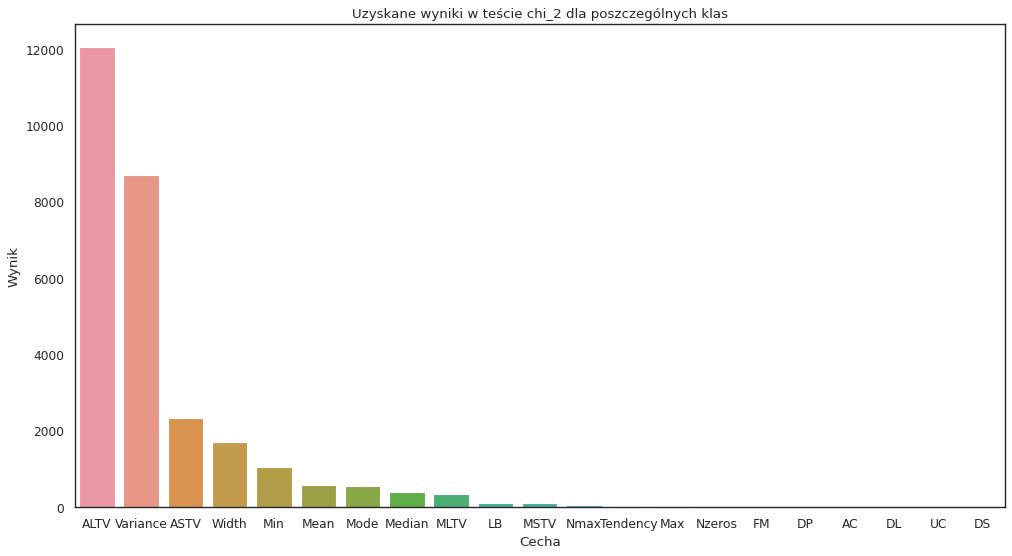

In [43]:
plt.figure(figsize=(15, 8), dpi=80)
plt.title('Uzyskane wyniki w teście chi_2 dla poszczególnych klas')
# plt.ylim(0, 20000)
string_index = [str(int) for int in chi_2.index]
sns.barplot(y='Wartosc', x='Cecha str', data=df_chi);
plt.xlabel("Cecha")
plt.ylabel("Wynik")
plt.show()

In [44]:
df = df[['ALTV', 'Variance', 'ASTV', 'NSP']]
y = df[y_type]
X = df[['ALTV', 'Variance', 'ASTV']]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=y)
df.head()

,ALTV,Variance,ASTV,NSP
1,43.0,73.0,73.0,2
2,0.0,12.0,17.0,1
3,0.0,13.0,16.0,1
4,0.0,13.0,16.0,1
5,0.0,11.0,16.0,1


## Rozkłady danych

In [127]:
def print_distribution(class_name):
    fig, ax = plt.subplots()
    X_train[class_name].plot.kde(ax=ax, legend=False)
    X_train[class_name].plot.hist(density=True, ax=ax, bins=15)
    ax.set_ylabel('Probability')
    ax.grid(axis='y')
    ax.set_facecolor('#d8dcd6')
    ax.set_title(class_name)
    ax.set_xlim(xmin=0)

def print_y(class_name):
    fig, ax = plt.subplots()
    y_train.plot.kde(ax=ax, legend=False)
    y_train.plot.hist(density=True, ax=ax)
    ax.set_ylabel('Probability')
    ax.grid(axis='y')
    ax.set_facecolor('#d8dcd6')
    ax.set_title(class_name)
    # ax.set_xlim(xmin=0)

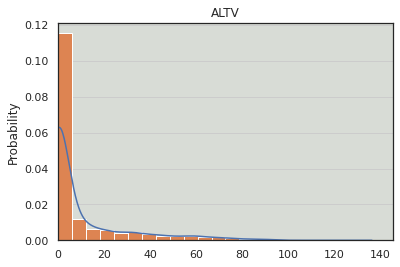

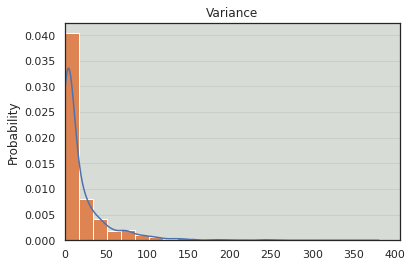

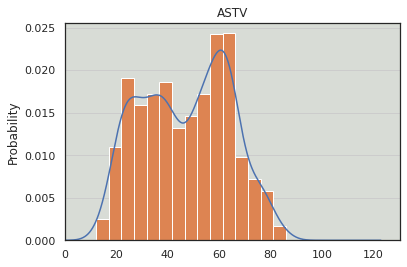

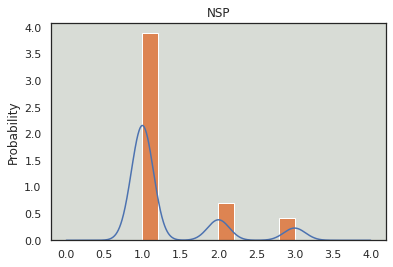

In [129]:
for class_name in df.columns:
    if class_name != 'NSP':
        print_distribution(class_name)
    else:
        print_y(class_name)

## Zbiory rozmyte typu I

In [47]:
print(df.shape)

(2126, 4)


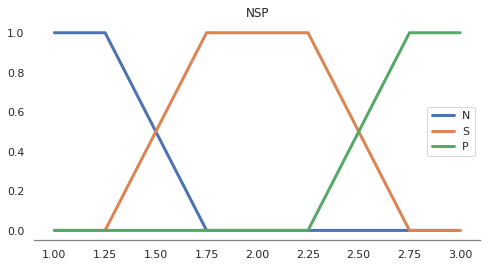

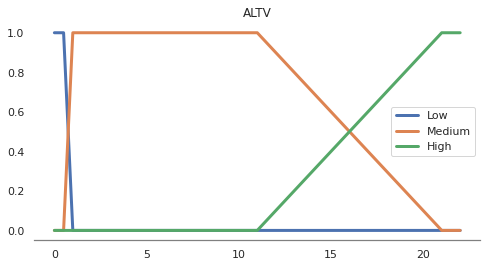

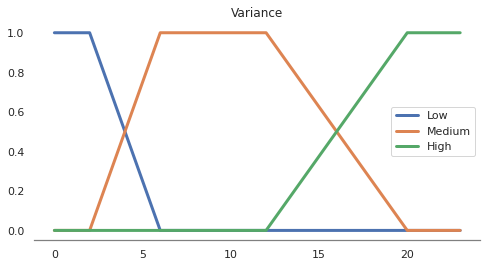

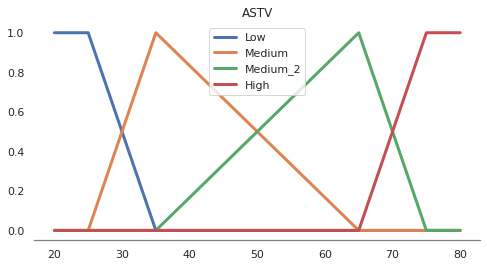

In [48]:
variables = {
    "ALTV": FuzzyVariable(
        universe_range=(0, 22),
        terms={
            "Low": [(0.5, 1), (1, 0)],
            "Medium": [(0.5, 0), (1, 1), (11,1), (21,0)],
            "High": [(11, 0), (21, 1)],
        },
    ),
    "Variance": FuzzyVariable(
        universe_range=(0, 23),
        terms={
            "Low": [(2, 1), (6, 0)], #żeby się w 4 przecinąływ połowie
            "Medium": [(2, 0), (6, 1), (12,1), (20,0)],
            "High": [(12, 0), (20, 1)], #żeby się w 16 przecinąływ połowie
        },
    ),
    "ASTV": FuzzyVariable(
        universe_range=(20, 80),
        terms={
            "Low": [(25, 1), (35, 0)],
            "Medium": [(25, 0), (35, 1), (65,0)],
            "Medium_2": [(35, 0), (65, 1), (75,0)],
            "High": [(65, 0), (75, 1)],
        },
    ),
    "NSP": FuzzyVariable(
        universe_range=(1, 3),
        terms={
            "N": [(1.25, 1), (1.75, 0)],
            "S": [(1.25, 0), (1.75, 1), (2.25, 1), (2.75,0)],
            "P": [(2.25, 0), (2.75, 1)],
        },
    ),
}

plt.figure(figsize=(8, 4))
plt.title('NSP')
variables["NSP"].plot()
plt.figure(figsize=(8, 4))
plt.title('ALTV')
variables["ALTV"].plot()
plt.figure(figsize=(8, 4))
plt.title('Variance')
variables["Variance"].plot()
plt.figure(figsize=(8, 4))
plt.title('ASTV')
variables["ASTV"].plot()

## Reguły od eksperta (drzewa)

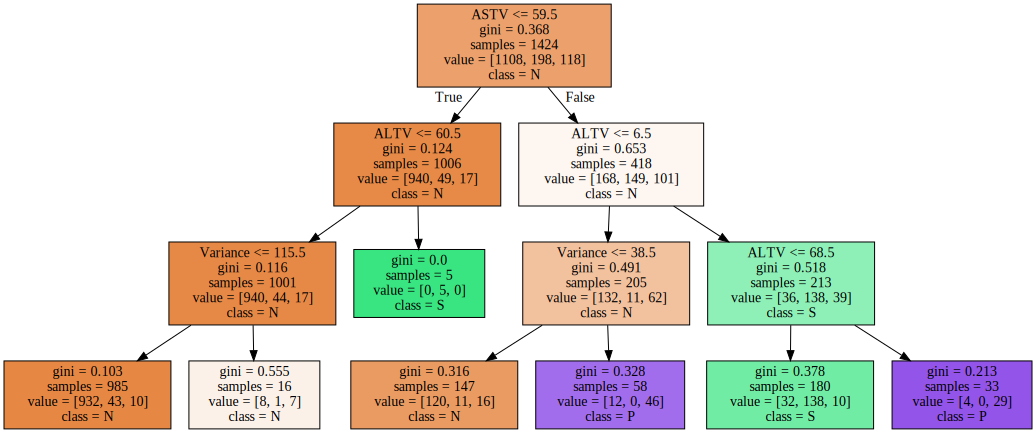

In [49]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree

# y_train=df["NSP"]
# X_train=df[["ALTV", "Variance", "ASTV"]]

clf = DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)

import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=["ALTV", "Variance", "ASTV"],  
                                class_names='NSP',
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

In [50]:
rules = [
    FuzzyRule(
        premise=[
            ("ASTV", "Medium"),
        ],
        consequence=[("NSP", "N")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "Low"),
        ],
        consequence=[("NSP", "N")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "Medium_2"),
            ("AND", "ALTV", "Low"),
        ],
        consequence=[("NSP", "N")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "High"),
            ("AND", "ALTV", "Medium"),
        ],
        consequence=[("NSP", "N")],
    ),
    FuzzyRule(
        premise=[
            ("ASTV", "High"),
            ("AND", "ALTV", "High"),
        ],
        consequence=[("NSP", "S")],
    ),
]

In [51]:
model = DecompositionalInference(
    and_operator="min", 
    or_operator="max", 
    implication_operator="Rc", 
    composition_operator="max-min", 
    production_link="max", 
    defuzzification_operator="cog"
)

## Sprawdzenie dokładności

In [53]:
correct = 0
ys=[]
preds=[]
for i in range(df.shape[0]):
    results = model(
        variables=variables,
        rules=rules,
        ALTV=df.iloc[i][0],
        Variance=df.iloc[i][1],
        ASTV=df.iloc[i][2],
    )
    y = df.iloc[i][3]
    pred = results[0]['NSP']
    pred = np.round(pred)
    if y==pred:
        correct+=1
    ys.append(pred)
results_1 = correct/df.shape[0]
print(f'Losowa dokładność:  {round(df.NSP.value_counts()[1] / df.shape[0] * 100, 2)}%')
print(f'Dokładność fuzzy I: {round(results_1*100, 2)}%')

Losowa dokładność:  77.85%
Dokładność fuzzy I: 78.79%


In [92]:
print(f1_score(np.ones_like(ys), preds, average='micro'))
print(f1_score(ys, preds, average='micro'))

0.8774928774928775
0.7792022792022792


In [137]:
correct = 0
ys=[]
preds=[]
for i in X_test.index:
    results = model(
        variables=variables,
        rules=rules,
        ALTV=X_test.loc[i][0],
        Variance=X_test.loc[i][1],
        ASTV=X_test.loc[i][2],
    )
    y = y_test.loc[i]
    pred = results[0]['NSP']
    pred = int(np.round(pred))
    if y==pred:
        correct+=1
    ys.append(y)
    preds.append(pred)
results_1 = correct/X_test.shape[0]
print(f'Losowa dokładność:  {round(y_test.value_counts()[1] / y_test.shape[0] * 100, 2)}%')
print(f'Dokładność fuzzy I: {round(results_1*100, 2)}%')
print(f1_score(np.ones_like(ys), preds, average='micro'))
print(f1_score(ys, preds, average='micro'))

Losowa dokładność:  77.92%
Dokładność fuzzy I: 77.92%
0.8774928774928775
0.7792022792022792


## Zbiory rozmyte typu II

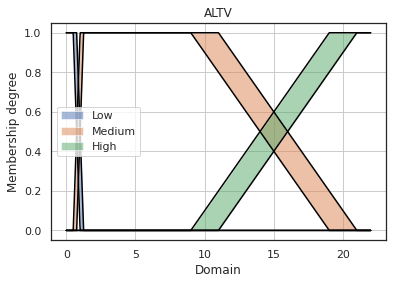

In [54]:
ALTV_domain = np.linspace(0, 22, 1001)
ALTV_RTri = IT2FS(ALTV_domain, 
             rtri_mf, [1.25, 0.75, 1], 
             rtri_mf, [1, 0.5, 1], check_set=True)
ALTV_LTri = IT2FS(ALTV_domain, 
             ltri_mf, [9, 19, 1], 
             ltri_mf, [11, 21, 1], check_set=True)
ALTV_Trapezoid = IT2FS(ALTV_domain, 
                  trapezoid_mf, [0.5, 1, 11, 21, 1], 
                  trapezoid_mf, [0.75, 1.25, 9, 19, 1], check_set=True)
IT2FS_plot(ALTV_RTri, ALTV_Trapezoid, ALTV_LTri, legends=['Low', 'Medium', 'High'], title='ALTV')

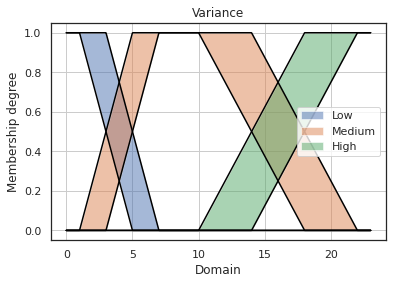

In [55]:
Variance_domain = np.linspace(0, 23, 1001)
Variance_RTri = IT2FS(Variance_domain, 
             rtri_mf, [7, 3, 1], 
             rtri_mf, [5, 1, 1], check_set=True)
Variance_LTri = IT2FS(Variance_domain, 
             ltri_mf, [10, 18, 1], 
             ltri_mf, [14, 22, 1], check_set=True)
Variance_Trapezoid = IT2FS(Variance_domain, 
                  trapezoid_mf, [1, 5, 14, 22, 1], 
                  trapezoid_mf, [3, 7, 10, 18, 1], check_set=True)
IT2FS_plot(Variance_RTri, Variance_Trapezoid, Variance_LTri, legends=['Low', 'Medium', 'High'], title='Variance')

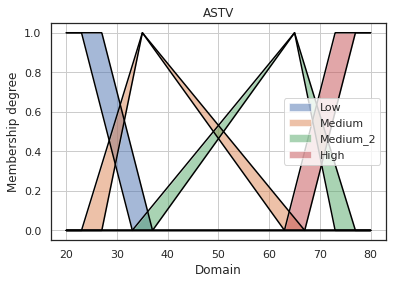

In [56]:
ASTV_domain = np.linspace(20, 80, 1001)
ASTV_RTri = IT2FS(ASTV_domain, 
             rtri_mf, [37, 27, 1], 
             rtri_mf, [33, 23, 1], check_set=True)
ASTV_Tri = IT2FS(ASTV_domain, 
                 tri_mf, [23, 35, 67, 1], 
                 tri_mf, [27, 35, 63, 1], check_set=True)
ASTV_Tri_2 = IT2FS(ASTV_domain, 
                   tri_mf, [33, 65, 77, 1], 
                   tri_mf, [37, 65, 73, 1], check_set=True) 
ASTV_LTri = IT2FS(ASTV_domain, 
             ltri_mf, [63, 73, 1], 
             ltri_mf, [67, 77, 1], check_set=True)

IT2FS_plot(ASTV_RTri, ASTV_Tri, ASTV_Tri_2, ASTV_LTri, legends=['Low', 'Medium', 'Medium_2', 'High'], title='ASTV')

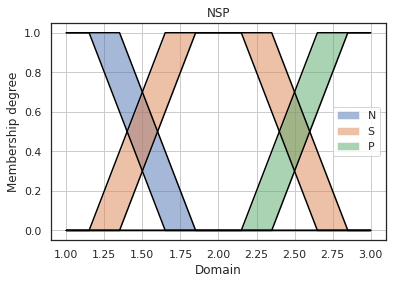

In [57]:
NSP_domain = np.linspace(1, 3, 1001)
NSP_RTri = IT2FS(NSP_domain, 
             rtri_mf, [1.85, 1.35 , 1], 
             rtri_mf, [1.65, 1.15, 1], check_set=True)
NSP_Trapezoid = IT2FS(NSP_domain, 
                  trapezoid_mf, [1.15, 1.65, 2.35, 2.85, 1], 
                  trapezoid_mf, [1.35, 1.85, 2.15, 2.65, 1], check_set=True)
NSP_LTri = IT2FS(NSP_domain, 
             ltri_mf, [2.15, 2.65, 1], 
             ltri_mf, [2.35, 2.85, 1], check_set=True)

IT2FS_plot(NSP_RTri, NSP_Trapezoid, NSP_LTri, legends=['N', 'S', 'P'], title='NSP',)

In [58]:
myIT2FLS = IT2Mamdani(min_t_norm, max_s_norm, method="Centroid", algorithm="KM")
myIT2FLS.add_input_variable("ALTV")
myIT2FLS.add_input_variable("Variance")
myIT2FLS.add_input_variable("ASTV")
myIT2FLS.add_output_variable("NSP")

myIT2FLS.add_rule([("ASTV", ASTV_Tri)], [("NSP", NSP_RTri)])
myIT2FLS.add_rule([("ASTV", ASTV_RTri)], [("NSP", NSP_RTri)])
myIT2FLS.add_rule([("ASTV", ASTV_Tri_2), ("ALTV", ALTV_RTri)], [("NSP", NSP_RTri)])
myIT2FLS.add_rule([("ASTV", ASTV_LTri), ("ALTV", ALTV_Trapezoid)], [("NSP", NSP_RTri)])
myIT2FLS.add_rule([("ASTV", ASTV_LTri), ("ALTV", ALTV_LTri)], [("NSP", NSP_Trapezoid)])

## Sprawdzenie dokładności

In [59]:
correct = 0
ys=[]
for i in range(df.shape[0]):
    it2out, tr = myIT2FLS.evaluate({"ALTV":df.iloc[i][0],
                                    "Variance":df.iloc[i][1],
                                    "ASTV":df.iloc[i][2]
    })
    y = df.iloc[i][3]
    pred = crisp(tr["NSP"])
    pred = np.round(pred)
    if y==pred:
        correct+=1
    ys.append(pred)
results_2 = correct/df.shape[0]

print(f'Losowa dokładność:   {round(df.NSP.value_counts()[1] / df.shape[0] * 100, 2)}%')
print(f'Dokładność fuzzy I:  {round(results_1*100, 2)}%')
print(f'Dokładność fuzzy II: {round(results_2*100, 2)}%')

Losowa dokładność:   77.85%
Dokładność fuzzy I:  78.79%
Dokładność fuzzy II: 82.46%


In [136]:
correct = 0
ys_2=[]
preds_2=[]
for i in X_test.index:
    it2out, tr = myIT2FLS.evaluate({"ALTV":X_test.loc[i][0],
                                    "Variance":X_test.loc[i][1],
                                    "ASTV":X_test.loc[i][2]
    })
    y = y_test.loc[i]
    pred = crisp(tr["NSP"])
    pred = int(np.round(pred))
    if y==pred:
        correct+=1
    ys_2.append(y)
    preds_2.append(pred)
results_2 = correct/X_test.shape[0]
f1_r = (f1_score(ys, np.ones_like(preds_2), average='weighted'))
f1_1 = (f1_score(ys, preds, average='weighted'))
f1_2 = (f1_score(ys_2, preds_2, average='weighted'))
print(f'Losowa dokładność:  {round(y_test.value_counts()[1] / y_test.shape[0] * 100, 2)}%')
print(f'Dokładność fuzzy I: {round(results_1*100, 2)}%')
print(f'Dokładność fuzzy II: {round(results_2*100, 2)}%')
print()
print(f'Losowa F1 weighted:   {round(f1_r* 100, 2)}%')
print(f'F1 weighted fuzzy I:  {round(f1_1*100, 2)}%')
print(f'F1 weighted fuzzy II: {round(f1_2*100, 2)}%')

Losowa dokładność:  77.92%
Dokładność fuzzy I: 77.92%
Dokładność fuzzy II: 81.05%

Losowa F1 weighted:   68.25%
F1 weighted fuzzy I:  73.86%
F1 weighted fuzzy II: 76.34%


# Wnioski

Mamdani II pozwala na uzyskanie lepszych wyników niż Mamdani I.